In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)


#1.load data
#TODO 进行数据增强跑起来试试看！！！
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

#这是已经划分好训练和测试数据集了的
trainset = torchvision.datasets.CIFAR100(root='./cifar-100-python', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./cifar-100-python', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = {19: 'cattle', 29: 'dinosaur', 0: 'apple', 11: 'boy', 1: 'aquarium_fish', 86: 'telephone',
           90: 'train', 28: 'cup', 23: 'cloud', 31: 'elephant', 39: 'keyboard', 96: 'willow_tree', 
           82: 'sunflower', 17: 'castle', 71: 'sea', 8: 'bicycle', 97: 'wolf', 80: 'squirrel', 
           74: 'shrew', 59: 'pine_tree', 70: 'rose', 87: 'television', 84: 'table', 64: 'possum', 
           52: 'oak_tree', 42: 'leopard', 47: 'maple_tree', 65: 'rabbit', 21: 'chimpanzee', 
           22: 'clock', 81: 'streetcar', 24: 'cockroach', 78: 'snake', 45: 'lobster', 49: 'mountain', 
           56: 'palm_tree', 76: 'skyscraper', 89: 'tractor', 73: 'shark', 14: 'butterfly', 9: 'bottle', 
           6: 'bee', 20: 'chair', 98: 'woman', 36: 'hamster', 55: 'otter', 72: 'seal', 43: 'lion', 51: 'mushroom', 
           35: 'girl', 83: 'sweet_pepper', 33: 'forest', 27: 'crocodile', 53: 'orange', 92: 'tulip', 50: 'mouse', 
           15: 'camel', 18: 'caterpillar', 46: 'man', 75: 'skunk', 38: 'kangaroo', 66: 'raccoon', 77: 'snail', 
           69: 'rocket', 95: 'whale', 99: 'worm', 93: 'turtle', 4: 'beaver', 61: 'plate', 94: 'wardrobe', 68: 'road', 
           34: 'fox', 32: 'flatfish', 88: 'tiger', 67: 'ray', 30: 'dolphin', 62: 'poppy', 63: 'porcupine', 40: 'lamp', 
           26: 'crab', 48: 'motorcycle', 79: 'spider', 85: 'tank', 54: 'orchid', 44: 'lizard', 7: 'beetle', 12: 'bridge', 
           2: 'baby', 41: 'lawn_mower', 37: 'house', 13: 'bus', 25: 'couch', 10: 'bowl', 57: 'pear', 5: 'bed', 
           60: 'plain', 91: 'trout', 3: 'bear', 58: 'pickup_truck', 16: 'can'}

Using PyTorch version: 1.13.1+cu117  Device: cuda
Files already downloaded and verified
Files already downloaded and verified


## 2. Define a ResNet


In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# from https://github.com/bubbliiiing/yolov4-tiny-pytorch
class CA_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CA_Block, self).__init__()
        
        self.conv_1x1 = nn.Conv2d(in_channels=channel, out_channels=channel//reduction, kernel_size=1, stride=1, bias=False)
 
        self.relu   = nn.ReLU()
        self.bn     = nn.BatchNorm2d(channel//reduction)
 
        self.F_h = nn.Conv2d(in_channels=channel//reduction, out_channels=channel, kernel_size=1, stride=1, bias=False)
        self.F_w = nn.Conv2d(in_channels=channel//reduction, out_channels=channel, kernel_size=1, stride=1, bias=False)
 
        self.sigmoid_h = nn.Sigmoid()
        self.sigmoid_w = nn.Sigmoid()
 
    def forward(self, x):
        _, _, h, w = x.size()
        
        x_h = torch.mean(x, dim = 3, keepdim = True).permute(0, 1, 3, 2)
        x_w = torch.mean(x, dim = 2, keepdim = True)
 
        x_cat_conv_relu = self.relu(self.bn(self.conv_1x1(torch.cat((x_h, x_w), 3))))
 
        x_cat_conv_split_h, x_cat_conv_split_w = x_cat_conv_relu.split([h, w], 3)
 
        s_h = self.sigmoid_h(self.F_h(x_cat_conv_split_h.permute(0, 1, 3, 2)))
        s_w = self.sigmoid_w(self.F_w(x_cat_conv_split_w))
 
        out = x * s_h.expand_as(x) * s_w.expand_as(x)
        return out

In [5]:
#残差块
#TODO 看具体残差块含义
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channel != self.expansion * out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, self.expansion * out_channel,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channel)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [12]:
class Net(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(Net, self).__init__()
        self.in_channel = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.CA = self.make_CA(512)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channel, num_blocks, stride):
        strides = [stride] + (num_blocks - 1) * [1]
        layers = []
        for stride in strides:
            layers.append(block(self.in_channel, out_channel, stride))
            self.in_channel = out_channel * block.expansion
        return nn.Sequential(*layers)
    
    def make_CA(self, out_channel):
        layers = []
        layers.append(CA_Block(self.in_channel, out_channel))
        self.in_channel = out_channel * 1
        return nn.Sequential(*layers)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

#超参都可以改！！！
def ResNet():
    return Net(BasicBlock, [2, 2, 2,2])#4个残差块？？？


net = ResNet().to(device)
print(net)

#一些超参
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [19]:
total = 0
for data, target in trainloader:
    target = target.to(device)
    total += target.size(0)
print(total)

50000


In [14]:
import torch.optim as optim

#注意注意注意： 每次运行这里时 先把前面的above都运行一遍！！！--》即使值改动了epoch 前面的也得执行一遍！！！
def validate(loss_vector, accuracy_vector):
    net.eval()
    total = 0
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        val_loss += criterion(output, target).data.item()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)#total就是一个 总数...

    val_loss /= total
    loss_vector.append(val_loss)

    accuracy = 100 * correct / total
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, total, accuracy))
       
#开始训练 
lossv, accv = [], []

epochs = 20#可调整--这里可以变成train函数
#train
for epoch in range(epochs):  # loop over the dataset multiple times
    

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    validate(lossv, accv)
print('Training Finished')

[1,    50] loss: 0.821
[1,   100] loss: 0.829
[1,   150] loss: 0.930
[1,   200] loss: 0.935
[1,   250] loss: 0.981
[1,   300] loss: 0.942
[1,   350] loss: 0.964

Validation set: Average loss: 0.0204, Accuracy: 4199/10000 (42%)

[2,    50] loss: 0.585
[2,   100] loss: 0.638
[2,   150] loss: 0.689
[2,   200] loss: 0.694
[2,   250] loss: 0.727
[2,   300] loss: 0.780
[2,   350] loss: 0.770

Validation set: Average loss: 0.0211, Accuracy: 4333/10000 (43%)

[3,    50] loss: 0.414
[3,   100] loss: 0.451
[3,   150] loss: 0.518
[3,   200] loss: 0.497
[3,   250] loss: 0.562
[3,   300] loss: 0.542
[3,   350] loss: 0.598

Validation set: Average loss: 0.0233, Accuracy: 4322/10000 (43%)

[4,    50] loss: 0.325
[4,   100] loss: 0.342
[4,   150] loss: 0.375
[4,   200] loss: 0.339
[4,   250] loss: 0.409
[4,   300] loss: 0.423
[4,   350] loss: 0.475

Validation set: Average loss: 0.0262, Accuracy: 4388/10000 (44%)

[5,    50] loss: 0.268
[5,   100] loss: 0.258
[5,   150] loss: 0.285
[5,   200] loss: 0.

Let’s quickly save our trained model:

In [21]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Text(0.5, 1.0, 'validation accuracy,epoch=5')

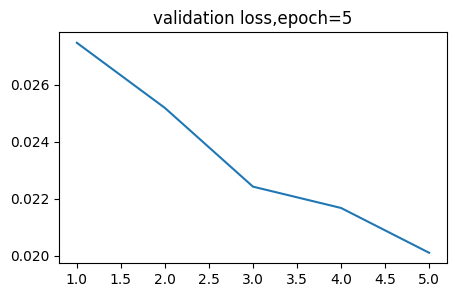

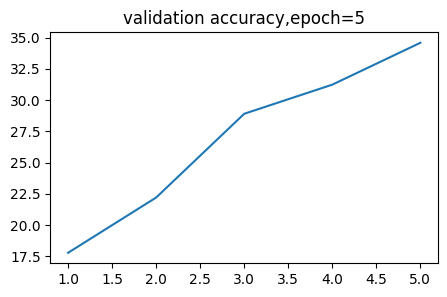

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss,epoch=%s'%epochs)

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy,epoch=%s'%epochs)